# Market Basket Analysis

## Introduction

* The data contains orders of 200,000 users with each user having between 4 and 100 orders 
* Each order in the data is classified as prior, train or test
* Prior orders describe the past behaviour of a user while train and test orders regard the future behaviour that we need to predict
* We will predict which previously purchased products (prior orders) will be in a user’s next order (train and test orders)


* This is a classification problem because we need to predict whether each pair of user and product is a reorder or not
* This is indicated by the value of the reordered variable, i.e. reordered = 1 or reordered = 0

In [3]:
import pandas as pd
import numpy as np
import gc
gc.enable()

## Dataset Description

* **orders**: This table includes all orders, namely prior, train, and test. It has single primary key (order_id)
* **order_products_train**: This table includes training orders. It has a composite primary key (order_id and product_id) and indicates whether a product in an order is a reorder or not (through the reordered variable)
* **order_products_prior** : This table includes prior orders. It has a composite primary key (order_id and product_id) and indicates whether a product in an order is a reorder or not (through the reordered variable)
* **products**: This table includes all products. It has a single primary key (product_id)
* **aisles**: This table includes all aisles. It has a single primary key (aisle_id)
* **departments**: This table includes all departments. It has a single primary key (department_id)

In [4]:
orders = pd.read_csv('/kaggle/input/instacart-market-basket-analysis/orders.csv')
order_products_train = pd.read_csv('/kaggle/input/instacart-market-basket-analysis/order_products__train.csv')
order_products_prior = pd.read_csv('/kaggle/input/instacart-market-basket-analysis/order_products__prior.csv')
products = pd.read_csv('/kaggle/input/instacart-market-basket-analysis/products.csv')
aisles = pd.read_csv('/kaggle/input/instacart-market-basket-analysis/aisles.csv')
departments = pd.read_csv('/kaggle/input/instacart-market-basket-analysis/departments.csv')

orders = orders.loc[orders.user_id.isin(orders.user_id.drop_duplicates().sample(frac = 0.30, random_state = 101))]

In [5]:
orders.head(5)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
50,2086598,6,prior,1,5,18,NaN
51,298250,6,prior,2,4,16,6.0
52,998866,6,prior,3,2,18,12.0
53,1528013,6,test,4,3,16,22.0
83,1224907,10,prior,1,2,14,NaN


In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1030204 entries, 50 to 3420933
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   order_id                1030204 non-null  int64  
 1   user_id                 1030204 non-null  int64  
 2   eval_set                1030204 non-null  object 
 3   order_number            1030204 non-null  int64  
 4   order_dow               1030204 non-null  int64  
 5   order_hour_of_day       1030204 non-null  int64  
 6   days_since_prior_order  968341 non-null   float64
dtypes: float64(1), int64(5), object(1)
memory usage: 62.9+ MB


In [7]:
order_products_train.head(5)

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [8]:
order_products_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384617 entries, 0 to 1384616
Data columns (total 4 columns):
 #   Column             Non-Null Count    Dtype
---  ------             --------------    -----
 0   order_id           1384617 non-null  int64
 1   product_id         1384617 non-null  int64
 2   add_to_cart_order  1384617 non-null  int64
 3   reordered          1384617 non-null  int64
dtypes: int64(4)
memory usage: 42.3 MB


In [9]:
order_products_prior.head(5)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [10]:
order_products_prior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
 #   Column             Dtype
---  ------             -----
 0   order_id           int64
 1   product_id         int64
 2   add_to_cart_order  int64
 3   reordered          int64
dtypes: int64(4)
memory usage: 989.8 MB


In [11]:
products.head(5)

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [12]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  int64 
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  int64 
 3   department_id  49688 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [13]:
aisles.head(5)

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [14]:
aisles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   aisle_id  134 non-null    int64 
 1   aisle     134 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.2+ KB


In [15]:
departments.head(5)

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [16]:
departments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   department_id  21 non-null     int64 
 1   department     21 non-null     object
dtypes: int64(1), object(1)
memory usage: 464.0+ bytes


# Reshaping the Data

We convert character variables into categories so we can use them in the creation of the model

In [17]:
aisles['aisle'] = aisles['aisle'].astype('category')
departments['department'] = departments['department'].astype('category')
orders['eval_set'] = orders['eval_set'].astype('category')
products['product_name'] = products['product_name'].astype('category')

# Merging Datasets 

A new DataFrame named <b>order_prior</b> which combines the DataFrames <b>orders</b> and <b>order_products_prior</b> is created

In [18]:
#order_products_prior includes prior orders only
order_prior = orders.merge(order_products_prior, on = 'order_id', how = 'inner')
order_prior.head(5)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2086598,6,prior,1,5,18,NaN,27521,1,0
1,2086598,6,prior,1,5,18,NaN,38293,2,0
2,2086598,6,prior,1,5,18,NaN,21903,3,0
3,2086598,6,prior,1,5,18,NaN,48679,4,0
4,298250,6,prior,2,4,16,6.0,38293,1,1


# Creating Predictor Variables
* <b>User predictors</b> describing the behavior of a user e.g. total number of orders of a user
* <b>Product predictors</b> describing characteristics of a product e.g. total number of times a product has been purchased
* <b>User & product predictors</b> describing the behavior of a user towards a specific product e.g. total times a user ordered a specific product

## Creating user predictors
- Number of orders per customer
- How frequent a customer has reordered products



**user_order** DataFrame to store the total number of placed orders per customer

In [19]:
#creating a new dataframe for user behaviour according to total orders placed by each user
user_order = order_prior.groupby('user_id')['order_number'].max().to_frame('user_total_orders')
user_order.head(5)

,user_total_orders
user_id,
6,3
10,5
17,40
19,9
25,3


In [20]:
#adding a index column 
user_order = user_order.reset_index()
user_order.head(5)

,user_id,user_total_orders
0,6,3
1,10,5
2,17,40
3,19,9
4,25,3


Frequency of a customer reordering products

In [21]:
#creating a new dataframe with ratio of a user reordering probability
user_reorder = order_prior.groupby('user_id')['reordered'].mean().to_frame('user_reordered_ratio')
user_reorder = user_reorder.reset_index()
user_reorder.head(5)

,user_id,user_reordered_ratio
0,6,0.142857
1,10,0.342657
2,17,0.717687
3,19,0.348039
4,25,0.095238


In [22]:
#left join to keep all the users from the user_order DataFrame
user_order = user_order.merge(user_reorder, on = 'user_id', how = 'left')  

In [23]:
del user_reorder
gc.collect()

68

In [24]:
user_order.head(5)

,user_id,user_total_orders,user_reordered_ratio
0,6,3,0.142857
1,10,5,0.342657
2,17,40,0.717687
3,19,9,0.348039
4,25,3,0.095238


## Creating product predictors
- Number of purchases for each product
- What is the probability for a product to be reordered

**product_purchase** DataFrame to stores the total number of purchases for each product (from all customers)

In [25]:
#creating a new dataframe with respect to product_id and number of times a product is purchased for product target variable
product_purchase = order_prior.groupby('product_id')['order_id'].count().to_frame('product_total_purchase')
product_purchase.head(5)

,product_total_purchase
product_id,
1,588
2,24
3,96
4,71
5,1


In [26]:
#indexing the newly created dataframe
product_purchase = product_purchase.reset_index()
product_purchase.head(5)

,product_id,product_total_purchase
0,1,588
1,2,24
2,3,96
3,4,71
4,5,1


Remove products with less than 35 purchases 

In [27]:
probability_reorder = order_prior.groupby('product_id').filter(lambda x : x.shape[0] > 35)
probability_reorder.head(5)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2086598,6,prior,1,5,18,NaN,27521,1,0
1,2086598,6,prior,1,5,18,NaN,38293,2,0
2,2086598,6,prior,1,5,18,NaN,21903,3,0
3,2086598,6,prior,1,5,18,NaN,48679,4,0
4,298250,6,prior,2,4,16,6.0,38293,1,1


Mean of reorders - how many times a product has been reordered divided by how many times has been ordered in total

In [28]:
probability_reorder = probability_reorder.groupby('product_id')['reordered'].mean().to_frame('product_reorder_ratio')
probability_reorder = probability_reorder.reset_index()
probability_reorder.head(5)

,product_id,product_reorder_ratio
0,1,0.647959
1,3,0.770833
2,4,0.281690
3,9,0.528302
4,10,0.513854


In [29]:
#left join to keep all the products from the product_purchase DataFrame
product_purchase = product_purchase.merge(probability_reorder, on = 'product_id', how = 'left') 

In [30]:
del probability_reorder
gc.collect()

0

In [31]:
product_purchase.head(5)

,product_id,product_total_purchase,product_reorder_ratio
0,1,588,0.647959
1,2,24,NaN
2,3,96,0.770833
3,4,71,0.281690
4,5,1,NaN


# Filling Missing Values

In [32]:
product_purchase['product_reorder_ratio'] = product_purchase['product_reorder_ratio'].fillna(value = 0)
product_purchase.head(5)

,product_id,product_total_purchase,product_reorder_ratio
0,1,588,0.647959
1,2,24,0.000000
2,3,96,0.770833
3,4,71,0.281690
4,5,1,0.000000


## Creating user-product predictors
- How many times a user bought a product
- How frequently a customer bought a product after its first purchase
- How many times a customer bought a product on its last 5 orders

**user_product** DataFrame contains how many times each user bought a particular product

In [33]:
#creating a new dataframe with respect to user_id and product_id for user-product target variable 
user_product = order_prior.groupby(['user_id','product_id'])['order_id'].count().to_frame('user_product_total')
user_product.head(5)

user_product_total
user_id product_id                    
6       8424                         1
        10644                        1
        11068                        1
        20323                        1
        21903                        2

In [34]:
#indexing the dataframe
user_product = user_product.reset_index()
user_product.head(5)

,user_id,product_id,user_product_total
0,6,8424,1
1,6,10644,1
2,6,11068,1
3,6,20323,1
4,6,21903,2


Frequency of a customer buying a product after its first purchase

In [35]:
#number of times a product is being bought by a user after initial purchase
times_bought = order_prior.groupby(['user_id','product_id'])[['order_id']].count()

In [36]:
times_bought.columns = ['times_bought']
times_bought.head(5)

times_bought
user_id product_id              
6       8424                   1
        10644                  1
        11068                  1
        20323                  1
        21903                  2

In [37]:
#total number of orders by each user
total_order = order_prior.groupby('user_id')['order_number'].max().to_frame('total_orders')
total_order.head(5)

,total_orders
user_id,
6,3
10,5
17,40
19,9
25,3


In [38]:
#creating a dataframe where a user brought a product for the first time 
first_order = order_prior.groupby(['user_id','product_id'])['order_number'].min().to_frame('first_order')
first_order = first_order.reset_index()
first_order.head(5)

,user_id,product_id,first_order
0,6,8424,3
1,6,10644,2
2,6,11068,2
3,6,20323,2
4,6,21903,1


In [39]:
#joining the total_order and first_order dataframes 
span = pd.merge(total_order, first_order, on = 'user_id', how = 'right')
span.head(5)

,user_id,total_orders,product_id,first_order
0,6,3,8424,3
1,6,3,10644,2
2,6,3,11068,2
3,6,3,20323,2
4,6,3,21903,1


In [40]:
#the +1 includes in the difference the first order were the product has been purchased
#finding the range in which a user can order i.e., total orders - first order 
#total orders placed since the user's order of a product
span['order_range'] = span.total_orders - span.first_order + 1
span.head(5)

,user_id,total_orders,product_id,first_order,order_range
0,6,3,8424,3,1
1,6,3,10644,2,2
2,6,3,11068,2,2
3,6,3,20323,2,2
4,6,3,21903,1,3


In [41]:
user_product_ratio = pd.merge(times_bought, span, on = ['user_id','product_id'], how = 'left')

In [42]:
user_product_ratio.head(5)

,user_id,product_id,times_bought,total_orders,first_order,order_range
0,6,8424,1,3,3,1
1,6,10644,1,3,2,2
2,6,11068,1,3,2,2
3,6,20323,1,3,2,2
4,6,21903,2,3,1,3


In [43]:
#This ratio is a metric that describes how many times a user bought a product out of how many times 
#she had the chance to a buy it (starting from her first purchase of the product)
user_product_ratio['user_reorder_ratio'] = user_product_ratio.times_bought / user_product_ratio.order_range

In [44]:
user_product_ratio.head(5)

,user_id,product_id,times_bought,total_orders,first_order,order_range,user_reorder_ratio
0,6,8424,1,3,3,1,1.000000
1,6,10644,1,3,2,2,0.500000
2,6,11068,1,3,2,2,0.500000
3,6,20323,1,3,2,2,0.500000
4,6,21903,2,3,1,3,0.666667


In [45]:
user_product_ratio = user_product_ratio.drop(['times_bought','total_orders','first_order','order_range'], axis = 1)
user_product_ratio.head(5)

,user_id,product_id,user_reorder_ratio
0,6,8424,1.000000
1,6,10644,0.500000
2,6,11068,0.500000
3,6,20323,0.500000
4,6,21903,0.666667


In [46]:
del [times_bought, first_order, span]

In [47]:
#a new dataframe is created which keeps all the features based on combination of user-products
#left join as we keep all user-products that we have created
user_product = user_product.merge(user_product_ratio, on = ['user_id','product_id'], how = 'left')

In [48]:
del user_product_ratio

In [49]:
user_product.head(5)

,user_id,product_id,user_product_total,user_reorder_ratio
0,6,8424,1,1.000000
1,6,10644,1,0.500000
2,6,11068,1,0.500000
3,6,20323,1,0.500000
4,6,21903,2,0.666667


Number of times a customer bought a product on their last 5 orders

In [50]:
#Create a new variable(column) which keeps the order_number for each order in reverse order
#Perform a .groupby() on users and products to get how many times each customer bought a product
order_prior['order_number_back'] = order_prior.groupby('user_id')['order_number'].transform(max) - order_prior.order_number + 1
order_prior.head(20)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,order_number_back
0,2086598,6,prior,1,5,18,NaN,27521,1,0,3
1,2086598,6,prior,1,5,18,NaN,38293,2,0,3
2,2086598,6,prior,1,5,18,NaN,21903,3,0,3
3,2086598,6,prior,1,5,18,NaN,48679,4,0,3
4,298250,6,prior,2,4,16,6.0,38293,1,1,2
5,298250,6,prior,2,4,16,6.0,20323,2,0,2
6,298250,6,prior,2,4,16,6.0,40992,3,0,2
7,298250,6,prior,2,4,16,6.0,21903,4,1,2
8,298250,6,prior,2,4,16,6.0,45007,5,0,2
9,298250,6,prior,2,4,16,6.0,11068,6,0,2


In [51]:
order_prior[order_prior.user_id == 10].head(10)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,order_number_back
14,1224907,10,prior,1,2,14,NaN,46979,1,0,5
15,1224907,10,prior,1,2,14,NaN,24852,2,0,5
16,1224907,10,prior,1,2,14,NaN,27104,3,0,5
17,1224907,10,prior,1,2,14,NaN,16797,4,0,5
18,1224907,10,prior,1,2,14,NaN,31717,5,0,5
19,68288,10,prior,2,5,15,30.0,46979,1,1,4
20,68288,10,prior,2,5,15,30.0,47380,2,0,4
21,68288,10,prior,2,5,15,30.0,20995,3,0,4
22,68288,10,prior,2,5,15,30.0,43014,4,0,4
23,68288,10,prior,2,5,15,30.0,15011,5,0,4


In [52]:
#With the use of order_number_back we can now select to keep only the last five orders of each customer
order_prior_5 = order_prior[order_prior.order_number_back <= 5]
order_prior_5.head(10)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,order_number_back
0,2086598,6,prior,1,5,18,NaN,27521,1,0,3
1,2086598,6,prior,1,5,18,NaN,38293,2,0,3
2,2086598,6,prior,1,5,18,NaN,21903,3,0,3
3,2086598,6,prior,1,5,18,NaN,48679,4,0,3
4,298250,6,prior,2,4,16,6.0,38293,1,1,2
5,298250,6,prior,2,4,16,6.0,20323,2,0,2
6,298250,6,prior,2,4,16,6.0,40992,3,0,2
7,298250,6,prior,2,4,16,6.0,21903,4,1,2
8,298250,6,prior,2,4,16,6.0,45007,5,0,2
9,298250,6,prior,2,4,16,6.0,11068,6,0,2


Calculating how many times each customer bought every product

In [53]:
#we perform a .groupby() on user_id & product_id. 
#With .count() we get how many times each customer bought a product
prev_five = order_prior_5.groupby(['user_id', 'product_id'])[['order_id']].count()

In [54]:
prev_five.columns = ['times_last_5']
prev_five.head(5)

times_last_5
user_id product_id              
6       8424                   1
        10644                  1
        11068                  1
        20323                  1
        21903                  2

In [55]:
#merge the new feature with user-product dataframe
user_product = user_product.merge(prev_five, on = ['user_id','product_id'], how = 'left')

In [56]:
del [order_prior_5, prev_five]

In [57]:
user_product.head(10)

,user_id,product_id,user_product_total,user_reorder_ratio,times_last_5
0,6,8424,1,1.000000,1.0
1,6,10644,1,0.500000,1.0
2,6,11068,1,0.500000,1.0
3,6,20323,1,0.500000,1.0
4,6,21903,2,0.666667,2.0
5,6,25659,1,1.000000,1.0
6,6,27521,1,0.333333,1.0
7,6,38293,2,0.666667,2.0
8,6,40992,1,0.500000,1.0
9,6,45007,1,0.500000,1.0


In [58]:
user_product = user_product.fillna(0)
user_product.head(10)

,user_id,product_id,user_product_total,user_reorder_ratio,times_last_5
0,6,8424,1,1.000000,1.0
1,6,10644,1,0.500000,1.0
2,6,11068,1,0.500000,1.0
3,6,20323,1,0.500000,1.0
4,6,21903,2,0.666667,2.0
5,6,25659,1,1.000000,1.0
6,6,27521,1,0.333333,1.0
7,6,38293,2,0.666667,2.0
8,6,40992,1,0.500000,1.0
9,6,45007,1,0.500000,1.0


# Merging all Features

In [59]:
#left join ensures that the new dataframe will have all observations of the user-product dataframe and matching observations based on  matching user_id key
data = user_product.merge(user_order, on  = 'user_id', how = 'left')

In [60]:
data.head(5)

,user_id,product_id,user_product_total,user_reorder_ratio,times_last_5,user_total_orders,user_reordered_ratio
0,6,8424,1,1.000000,1.0,3,0.142857
1,6,10644,1,0.500000,1.0,3,0.142857
2,6,11068,1,0.500000,1.0,3,0.142857
3,6,20323,1,0.500000,1.0,3,0.142857
4,6,21903,2,0.666667,2.0,3,0.142857


In [61]:
#left join ensures that the new dataframe will have all observations of the product dataframe and matching observations based on matching product_id key
data = data.merge(product_purchase, on = 'product_id', how = 'left')
data.head(5)

,user_id,product_id,user_product_total,user_reorder_ratio,times_last_5,user_total_orders,user_reordered_ratio,product_total_purchase,product_reorder_ratio
0,6,8424,1,1.000000,1.0,3,0.142857,12292,0.650504
1,6,10644,1,0.500000,1.0,3,0.142857,3631,0.416690
2,6,11068,1,0.500000,1.0,3,0.142857,3069,0.584881
3,6,20323,1,0.500000,1.0,3,0.142857,695,0.532374
4,6,21903,2,0.666667,2.0,3,0.142857,73243,0.773808


In [62]:
del order_prior, user_order, product_purchase, user_product
gc.collect()

17

# Creating Train and Test Dataframes

In [63]:
#keep only the future orders from all customers: train & test
orders_future = orders[((orders.eval_set == 'train') | (orders.eval_set == 'test'))]

In [64]:
orders_future = orders_future[['user_id','eval_set','order_id']]
orders_future.head(10)

,user_id,eval_set,order_id
53,6,test,1528013
88,10,train,1822501
200,17,train,2180313
217,19,test,1735923
300,25,test,1411408
395,27,train,2614670
495,35,test,707453
588,40,test,2431024
652,46,train,1947848
669,48,train,2924697


In [65]:
#bring the info of the future orders to data DF
data = data.merge(orders_future, on  = 'user_id', how = 'left')
data.head(10)

,user_id,product_id,user_product_total,user_reorder_ratio,times_last_5,user_total_orders,user_reordered_ratio,product_total_purchase,product_reorder_ratio,eval_set,order_id
0,6,8424,1,1.000000,1.0,3,0.142857,12292,0.650504,test,1528013
1,6,10644,1,0.500000,1.0,3,0.142857,3631,0.416690,test,1528013
2,6,11068,1,0.500000,1.0,3,0.142857,3069,0.584881,test,1528013
3,6,20323,1,0.500000,1.0,3,0.142857,695,0.532374,test,1528013
4,6,21903,2,0.666667,2.0,3,0.142857,73243,0.773808,test,1528013
5,6,25659,1,1.000000,1.0,3,0.142857,7940,0.521537,test,1528013
6,6,27521,1,0.333333,1.0,3,0.142857,13068,0.696434,test,1528013
7,6,38293,2,0.666667,2.0,3,0.142857,8088,0.646390,test,1528013
8,6,40992,1,0.500000,1.0,3,0.142857,1312,0.487805,test,1528013
9,6,45007,1,0.500000,1.0,3,0.142857,31596,0.693157,test,1528013


### Preparing Training Set

In [66]:
#Keep only the customers who we know what they bought in their future order
data_train = data[data.eval_set == 'train']
data_train.head(10)

,user_id,product_id,user_product_total,user_reorder_ratio,times_last_5,user_total_orders,user_reordered_ratio,product_total_purchase,product_reorder_ratio,eval_set,order_id
12,10,260,2,1.000000,2.0,5,0.342657,7360,0.637636,train,1822501
13,10,1529,3,0.750000,3.0,5,0.342657,2602,0.439277,train,1822501
14,10,4920,1,0.333333,1.0,5,0.342657,25055,0.669966,train,1822501
15,10,5450,1,0.333333,1.0,5,0.342657,14684,0.669572,train,1822501
16,10,5646,1,0.250000,1.0,5,0.342657,4579,0.645993,train,1822501
17,10,5769,1,0.333333,1.0,5,0.342657,3198,0.460600,train,1822501
18,10,5818,1,0.250000,1.0,5,0.342657,4844,0.549546,train,1822501
19,10,7632,1,0.250000,1.0,5,0.342657,872,0.174312,train,1822501
20,10,7746,1,0.250000,1.0,5,0.342657,1622,0.159679,train,1822501
21,10,8988,1,0.250000,1.0,5,0.342657,965,0.172021,train,1822501


In [67]:
#Get from order_products_train all the products that the train users bought bought in their future order by joining the two dataframes
data_train = data_train.merge(order_products_train[['product_id','order_id','reordered']], on = ['product_id','order_id'], how = 'left')

In [68]:
data_train.head(10)

,user_id,product_id,user_product_total,user_reorder_ratio,times_last_5,user_total_orders,user_reordered_ratio,product_total_purchase,product_reorder_ratio,eval_set,order_id,reordered
0,10,260,2,1.000000,2.0,5,0.342657,7360,0.637636,train,1822501,NaN
1,10,1529,3,0.750000,3.0,5,0.342657,2602,0.439277,train,1822501,NaN
2,10,4920,1,0.333333,1.0,5,0.342657,25055,0.669966,train,1822501,NaN
3,10,5450,1,0.333333,1.0,5,0.342657,14684,0.669572,train,1822501,NaN
4,10,5646,1,0.250000,1.0,5,0.342657,4579,0.645993,train,1822501,NaN
5,10,5769,1,0.333333,1.0,5,0.342657,3198,0.460600,train,1822501,NaN
6,10,5818,1,0.250000,1.0,5,0.342657,4844,0.549546,train,1822501,NaN
7,10,7632,1,0.250000,1.0,5,0.342657,872,0.174312,train,1822501,NaN
8,10,7746,1,0.250000,1.0,5,0.342657,1622,0.159679,train,1822501,NaN
9,10,8988,1,0.250000,1.0,5,0.342657,965,0.172021,train,1822501,NaN


In [69]:
data_train['reordered'] = data_train['reordered'].fillna(0)
data_train.head(10)

,user_id,product_id,user_product_total,user_reorder_ratio,times_last_5,user_total_orders,user_reordered_ratio,product_total_purchase,product_reorder_ratio,eval_set,order_id,reordered
0,10,260,2,1.000000,2.0,5,0.342657,7360,0.637636,train,1822501,0.0
1,10,1529,3,0.750000,3.0,5,0.342657,2602,0.439277,train,1822501,0.0
2,10,4920,1,0.333333,1.0,5,0.342657,25055,0.669966,train,1822501,0.0
3,10,5450,1,0.333333,1.0,5,0.342657,14684,0.669572,train,1822501,0.0
4,10,5646,1,0.250000,1.0,5,0.342657,4579,0.645993,train,1822501,0.0
5,10,5769,1,0.333333,1.0,5,0.342657,3198,0.460600,train,1822501,0.0
6,10,5818,1,0.250000,1.0,5,0.342657,4844,0.549546,train,1822501,0.0
7,10,7632,1,0.250000,1.0,5,0.342657,872,0.174312,train,1822501,0.0
8,10,7746,1,0.250000,1.0,5,0.342657,1622,0.159679,train,1822501,0.0
9,10,8988,1,0.250000,1.0,5,0.342657,965,0.172021,train,1822501,0.0


In [70]:
#set user_id and product_id as the index of the DF
data_train = data_train.set_index(['user_id','product_id'])
data_train.head(10)

user_product_total  user_reorder_ratio  times_last_5  \
user_id product_id                                                         
10      260                          2            1.000000           2.0   
        1529                         3            0.750000           3.0   
        4920                         1            0.333333           1.0   
        5450                         1            0.333333           1.0   
        5646                         1            0.250000           1.0   
        5769                         1            0.333333           1.0   
        5818                         1            0.250000           1.0   
        7632                         1            0.250000           1.0   
        7746                         1            0.250000           1.0   
        8988                         1            0.250000           1.0   

                    user_total_orders  user_reordered_ratio  \
user_id product_id                                            
10      260                         5              0.342657   
        1529                        5              0.342657   
        4920                        5              0.342657   
        5450                        5              0.342657   
        5646                        5              0.342657   
        5769                        5              0.342657   
        5818                        5              0.342657   
        7632                        5              0.342657   
        7746                        5              0.342657   
        8988                        5              0.342657   

                    product_total_purchase  product_reorder_ratio eval_set  \
user_id product_id                                                           
10      260                           7360               0.637636    train   
        1529                          2602               0.439277    train   
        4920                         25055               0.669966    train   
        5450                         14684               0.669572    train   
        5646                          4579               0.645993    train   
        5769                          3198               0.460600    train   
        5818                          4844               0.549546    train   
        7632                           872               0.174312    train   
        7746                          1622               0.159679    train   
        8988                           965               0.172021    train   

                    order_id  reordered  
user_id product_id                       
10      260          1822501        0.0  
        1529         1822501        0.0  
        4920         1822501        0.0  
        5450         1822501        0.0  
        5646         1822501        0.0  
        5769         1822501        0.0  
        5818         1822501        0.0  
        7632         1822501        0.0  
        7746         1822501        0.0  
        8988         1822501        0.0

In [71]:
#remove all non-predictor variables
data_train = data_train.drop(['eval_set','order_id'], axis = 1)
data_train.head(10)

user_product_total  user_reorder_ratio  times_last_5  \
user_id product_id                                                         
10      260                          2            1.000000           2.0   
        1529                         3            0.750000           3.0   
        4920                         1            0.333333           1.0   
        5450                         1            0.333333           1.0   
        5646                         1            0.250000           1.0   
        5769                         1            0.333333           1.0   
        5818                         1            0.250000           1.0   
        7632                         1            0.250000           1.0   
        7746                         1            0.250000           1.0   
        8988                         1            0.250000           1.0   

                    user_total_orders  user_reordered_ratio  \
user_id product_id                                            
10      260                         5              0.342657   
        1529                        5              0.342657   
        4920                        5              0.342657   
        5450                        5              0.342657   
        5646                        5              0.342657   
        5769                        5              0.342657   
        5818                        5              0.342657   
        7632                        5              0.342657   
        7746                        5              0.342657   
        8988                        5              0.342657   

                    product_total_purchase  product_reorder_ratio  reordered  
user_id product_id                                                            
10      260                           7360               0.637636        0.0  
        1529                          2602               0.439277        0.0  
        4920                         25055               0.669966        0.0  
        5450                         14684               0.669572        0.0  
        5646                          4579               0.645993        0.0  
        5769                          3198               0.460600        0.0  
        5818                          4844               0.549546        0.0  
        7632                           872               0.174312        0.0  
        7746                          1622               0.159679        0.0  
        8988                           965               0.172021        0.0

### Preparing Test Set

In [72]:
#Keep only the future orders from customers who are labelled as test
data_test = data[data.eval_set == 'test']

In [73]:
data_test.head(10)

,user_id,product_id,user_product_total,user_reorder_ratio,times_last_5,user_total_orders,user_reordered_ratio,product_total_purchase,product_reorder_ratio,eval_set,order_id
0,6,8424,1,1.000000,1.0,3,0.142857,12292,0.650504,test,1528013
1,6,10644,1,0.500000,1.0,3,0.142857,3631,0.416690,test,1528013
2,6,11068,1,0.500000,1.0,3,0.142857,3069,0.584881,test,1528013
3,6,20323,1,0.500000,1.0,3,0.142857,695,0.532374,test,1528013
4,6,21903,2,0.666667,2.0,3,0.142857,73243,0.773808,test,1528013
5,6,25659,1,1.000000,1.0,3,0.142857,7940,0.521537,test,1528013
6,6,27521,1,0.333333,1.0,3,0.142857,13068,0.696434,test,1528013
7,6,38293,2,0.666667,2.0,3,0.142857,8088,0.646390,test,1528013
8,6,40992,1,0.500000,1.0,3,0.142857,1312,0.487805,test,1528013
9,6,45007,1,0.500000,1.0,3,0.142857,31596,0.693157,test,1528013


In [74]:
#set user_id and product_id as the index of the DF
data_test = data_test = data_test.set_index(['user_id','product_id'])

In [75]:
data_test.head(10)

user_product_total  user_reorder_ratio  times_last_5  \
user_id product_id                                                         
6       8424                         1            1.000000           1.0   
        10644                        1            0.500000           1.0   
        11068                        1            0.500000           1.0   
        20323                        1            0.500000           1.0   
        21903                        2            0.666667           2.0   
        25659                        1            1.000000           1.0   
        27521                        1            0.333333           1.0   
        38293                        2            0.666667           2.0   
        40992                        1            0.500000           1.0   
        45007                        1            0.500000           1.0   

                    user_total_orders  user_reordered_ratio  \
user_id product_id                                            
6       8424                        3              0.142857   
        10644                       3              0.142857   
        11068                       3              0.142857   
        20323                       3              0.142857   
        21903                       3              0.142857   
        25659                       3              0.142857   
        27521                       3              0.142857   
        38293                       3              0.142857   
        40992                       3              0.142857   
        45007                       3              0.142857   

                    product_total_purchase  product_reorder_ratio eval_set  \
user_id product_id                                                           
6       8424                         12292               0.650504     test   
        10644                         3631               0.416690     test   
        11068                         3069               0.584881     test   
        20323                          695               0.532374     test   
        21903                        73243               0.773808     test   
        25659                         7940               0.521537     test   
        27521                        13068               0.696434     test   
        38293                         8088               0.646390     test   
        40992                         1312               0.487805     test   
        45007                        31596               0.693157     test   

                    order_id  
user_id product_id            
6       8424         1528013  
        10644        1528013  
        11068        1528013  
        20323        1528013  
        21903        1528013  
        25659        1528013  
        27521        1528013  
        38293        1528013  
        40992        1528013  
        45007        1528013

In [76]:
#remove all non-predictor variables
data_test = data_test.drop(['eval_set','order_id'], axis = 1)
data_test.head(5)

user_product_total  user_reorder_ratio  times_last_5  \
user_id product_id                                                         
6       8424                         1            1.000000           1.0   
        10644                        1            0.500000           1.0   
        11068                        1            0.500000           1.0   
        20323                        1            0.500000           1.0   
        21903                        2            0.666667           2.0   

                    user_total_orders  user_reordered_ratio  \
user_id product_id                                            
6       8424                        3              0.142857   
        10644                       3              0.142857   
        11068                       3              0.142857   
        20323                       3              0.142857   
        21903                       3              0.142857   

                    product_total_purchase  product_reorder_ratio  
user_id product_id                                                 
6       8424                         12292               0.650504  
        10644                         3631               0.416690  
        11068                         3069               0.584881  
        20323                          695               0.532374  
        21903                        73243               0.773808

# XGBoost 

In [77]:
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [78]:
#split dataframe into X_train and y_train
X_train, y_train = data_train.drop('reordered', axis = 1), data_train.reordered

In [79]:
#set boosting parameters
parameters = {'eval_metric':'logloss',
             'max_depth':'5',
             'colsample_bytree':'0.4',
             'subsample':'0.75'}

In [80]:
#INSTANTIATE XGBClassifier()
xgbc = xgb.XGBClassifier(objective='binary:logistic', parameter=parameters, num_boost_round = 10)

In [81]:
#train model
model = xgbc.fit(X_train, y_train)

[08:47:48] WARNING: ../src/learner.cc:767: 
Parameters: { "num_boost_round", "parameter" } are not used.



In [82]:
import matplotlib.pyplot as plt

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

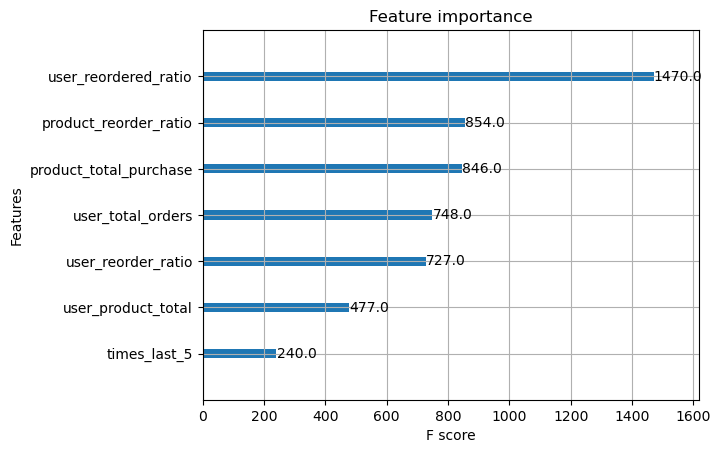

In [83]:
xgb.plot_importance(model)

In [84]:
#With method .get_params() we retrieve the parameters of our fitting model
model.get_xgb_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'eval_metric': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'monotone_constraints': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'parameter': {'eval_metric': 'logloss',
  'max_depth': '5',
  'colsample_bytree': '0.4',
  'subsample': '0.75'},
 'num_boost_round': 10}

These parameters do not necessarily create the best fitting model (in terms of prediction score). The method .GridSearchCV( ) can make several trials to define the best parameters for our fitting model.

In [85]:
from sklearn.model_selection import GridSearchCV

In [86]:
#Set booster's range of parameters
#More parameters means that GridSearch will create and evaluate more models
paramGrid = {'max_depth':[5,10],
            'colsample_bytree':[0.3,0.4]}

In [87]:
#INSTANTIATE XGBClassifier()
xgbc = xgb.XGBClassifier(objective='binary:logistic', eval_metric = 'logloss', num_boost_round = 10)

In [88]:
#define how to train the models
gridsearch = GridSearchCV(xgbc, paramGrid, cv = 3, verbose = 2, n_jobs = 1)

In [89]:
#train the models with the combination of different parameters
#execution if GridSearch
model = gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[08:50:56] WARNING: ../src/learner.cc:767: 
Parameters: { "num_boost_round" } are not used.

[CV] END ..................colsample_bytree=0.3, max_depth=5; total time=  51.7s
[08:51:48] WARNING: ../src/learner.cc:767: 
Parameters: { "num_boost_round" } are not used.

[CV] END ..................colsample_bytree=0.3, max_depth=5; total time=  55.3s
[08:52:43] WARNING: ../src/learner.cc:767: 
Parameters: { "num_boost_round" } are not used.

[CV] END ..................colsample_bytree=0.3, max_depth=5; total time=  53.3s
[08:53:37] WARNING: ../src/learner.cc:767: 
Parameters: { "num_boost_round" } are not used.

[CV] END .................colsample_bytree=0.3, max_depth=10; total time= 1.6min
[08:55:14] WARNING: ../src/learner.cc:767: 
Parameters: { "num_boost_round" } are not used.

[CV] END .................colsample_bytree=0.3, max_depth=10; total time= 1.7min
[08:56:56] WARNING: ../src/learner.cc:767: 
Parameters: { "num_boost_r

In [90]:
print("The best parameters are: /n",  gridsearch.best_params_)

The best parameters are: /n {'colsample_bytree': 0.3, 'max_depth': 5}


In [91]:
#store the model for prediction
model = gridsearch.best_estimator_

In [92]:
model.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.3,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'logloss',
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 5,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'num_boost_round': 10}

# Apply predictive model

In [93]:
#custom threshold prediction probability
test_pred = (model.predict_proba(data_test)[:,1] >= 0.21).astype(int)
test_pred[0:20]

array([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [94]:
#Save the prediction on a new column in the data_test DF
data_test['prediction'] = test_pred

In [95]:
data_test.head(10)

user_product_total  user_reorder_ratio  times_last_5  \
user_id product_id                                                         
6       8424                         1            1.000000           1.0   
        10644                        1            0.500000           1.0   
        11068                        1            0.500000           1.0   
        20323                        1            0.500000           1.0   
        21903                        2            0.666667           2.0   
        25659                        1            1.000000           1.0   
        27521                        1            0.333333           1.0   
        38293                        2            0.666667           2.0   
        40992                        1            0.500000           1.0   
        45007                        1            0.500000           1.0   

                    user_total_orders  user_reordered_ratio  \
user_id product_id                                            
6       8424                        3              0.142857   
        10644                       3              0.142857   
        11068                       3              0.142857   
        20323                       3              0.142857   
        21903                       3              0.142857   
        25659                       3              0.142857   
        27521                       3              0.142857   
        38293                       3              0.142857   
        40992                       3              0.142857   
        45007                       3              0.142857   

                    product_total_purchase  product_reorder_ratio  prediction  
user_id product_id                                                             
6       8424                         12292               0.650504           0  
        10644                         3631               0.416690           0  
        11068                         3069               0.584881           0  
        20323                          695               0.532374           0  
        21903                        73243               0.773808           1  
        25659                         7940               0.521537           0  
        27521                        13068               0.696434           0  
        38293                         8088               0.646390           1  
        40992                         1312               0.487805           0  
        45007                        31596               0.693157           0

In [96]:
final = data_test.reset_index()

In [97]:
#Keep only the required columns
final = final[['product_id', 'user_id', 'prediction']]

In [98]:
gc.collect()

125

In [99]:
final.head(20)

,product_id,user_id,prediction
0,8424,6,0
1,10644,6,0
2,11068,6,0
3,20323,6,0
4,21903,6,1
5,25659,6,0
6,27521,6,0
7,38293,6,1
8,40992,6,0
9,45007,6,0


In [100]:
#merging the final dataframe with products
final = final.merge(products, on = ['product_id'], how = 'inner')

In [101]:
final

,product_id,user_id,prediction,product_name,aisle_id,department_id
0,8424,6,0,Broccoli Crown,83,4
1,8424,94,0,Broccoli Crown,83,4
2,8424,381,0,Broccoli Crown,83,4
3,8424,450,0,Broccoli Crown,83,4
4,8424,463,0,Broccoli Crown,83,4
...,...,...,...,...,...,...
1460946,43684,206182,0,Triple Berry Layer Fruit Snack,50,19
1460947,16315,206201,0,Nature's Way Long Grain & Wild Rice Rice Mix,4,9
1460948,24110,206201,0,Blasted Chocolatey Chip Marshmallow Rice Krisp...,45,19
1460949,33935,206201,0,Double Stuf Chocolate/Chocolate Variety Pack S...,100,21


In [102]:
#obtain order_id for each user_id for every test user
order_test = orders.loc[orders.eval_set == 'test', ('user_id', 'order_id')]
order_test.head()

,user_id,order_id
53,6,1528013
217,19,1735923
300,25,1411408
495,35,707453
588,40,2431024


In [103]:
#merge the predictions 
final = final.merge(order_test, on  = 'user_id', how = 'left')
final.head()

,product_id,user_id,prediction,product_name,aisle_id,department_id,order_id
0,8424,6,0,Broccoli Crown,83,4,1528013
1,8424,94,0,Broccoli Crown,83,4,622677
2,8424,381,0,Broccoli Crown,83,4,1185710
3,8424,450,0,Broccoli Crown,83,4,2730481
4,8424,463,0,Broccoli Crown,83,4,1493300


In [104]:
#remove undesired columns
final = final.drop(['user_id', 'aisle_id', 'department_id'], axis = 1)

In [105]:
final['product_id'] = final.product_id.astype(int)

In [106]:
del order_test

In [107]:
gc.collect()

0

In [108]:
final.head()

,product_id,prediction,product_name,order_id
0,8424,0,Broccoli Crown,1528013
1,8424,0,Broccoli Crown,622677
2,8424,0,Broccoli Crown,1185710
3,8424,0,Broccoli Crown,2730481
4,8424,0,Broccoli Crown,1493300


In [109]:
#In this dictionary we will place as index the order_id and as values all the product name and id that the order will have
d = dict()
for row in final.itertuples():
    if row.prediction == 1:
        try:
            d[row.order_id] += ' ' + str(row.product_id) + ' ' +  str(row.product_name)
        except:
            d[row.order_id] = str(row.product_id) + ' ' + str(row.product_name)

for order in final.order_id:
    if order not in d:
        d[order] = 'None'

In [110]:
gc.collect()

0

In [111]:
from pprint import pprint
k = list(d.items())[:5]
pprint(k)

[(1176544,
  '8424 Broccoli Crown 34969 Red Vine Tomato 20842 Total 0% Greek Yogurt 11494 '
  'Cookie Dough Ice Cream Chocolate Chip 7035 Peanut Butter Ice Cream Cup '
  "16710 Non Dairy Coffee Caramel Fudge 36029 S'mores Ice Cream"),
 (1543051,
  '8424 Broccoli Crown 13176 Bag of Organic Bananas 19678 Organic Russet '
  'Potato 33198 Sparkling Natural Mineral Water 16589 Plantain Chips 11784 '
  'Duck Eggs'),
 (334377,
  '8424 Broccoli Crown 8518 Organic Red Onion 21137 Organic Strawberries 39275 '
  'Organic Blueberries 45066 Honeycrisp Apple 47766 Organic Avocado 13176 Bag '
  'of Organic Bananas 47626 Large Lemon 35221 Lime Sparkling Water 42265 '
  'Organic Baby Carrots 7781 Organic Sticks Low Moisture Part Skim Mozzarella '
  'String Cheese 19505 Sliced Mushrooms 26346 Organic Skim Milk'),
 (2362483,
  '8424 Broccoli Crown 48679 Organic Garnet Sweet Potato (Yam) 43772 Cherubs '
  'Heavenly Salad Tomatoes 21137 Organic Strawberries 11520 Large Alfresco '
  'Eggs 27864 Butter Crois

In [112]:
sub = pd.DataFrame.from_dict(d, orient = 'index')
sub.reset_index(inplace = True)

In [113]:
sub.columns = ['order_id', 'product']

In [114]:
#final prediction dataframe
sub.head()

,order_id,product
0,1176544,8424 Broccoli Crown 34969 Red Vine Tomato 2084...
1,1543051,8424 Broccoli Crown 13176 Bag of Organic Banan...
2,334377,8424 Broccoli Crown 8518 Organic Red Onion 211...
3,2362483,8424 Broccoli Crown 48679 Organic Garnet Sweet...
4,1005664,8424 Broccoli Crown 21903 Organic Baby Spinach...


In [115]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot

In [116]:
X_train, X_test, y_train, y_test = train_test_split(data_train.drop('reordered', axis=1), data_train.reordered, test_size=0.8, random_state=42)

In [117]:
train_scores, test_scores = list(), list()

In [118]:
#Checking over/under fitting
#colsample_bytree = 0.3 from GridSearchCV()'s best_params_ 
values = [i for i in range(1, 21)]

for i in values:
	model = xgb.XGBClassifier(max_depth=i, colsample_bytree = 0.3)
	model.fit(X_train, y_train)
	train_yhat = model.predict(X_train)
	train_acc = accuracy_score(y_train, train_yhat)
	train_scores.append(train_acc)
	test_yhat = model.predict(X_test)
	test_acc = accuracy_score(y_test, test_yhat)
	test_scores.append(test_acc)
	print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))

>1, train: 0.909, test: 0.909
>2, train: 0.909, test: 0.909
>3, train: 0.909, test: 0.909
>4, train: 0.909, test: 0.909
>5, train: 0.910, test: 0.909
>6, train: 0.911, test: 0.909
>7, train: 0.912, test: 0.909
>8, train: 0.913, test: 0.909
>9, train: 0.915, test: 0.908
>10, train: 0.917, test: 0.908
>11, train: 0.919, test: 0.908
>12, train: 0.921, test: 0.907
>13, train: 0.923, test: 0.907
>14, train: 0.927, test: 0.907
>15, train: 0.929, test: 0.907
>16, train: 0.933, test: 0.906
>17, train: 0.936, test: 0.906
>18, train: 0.939, test: 0.905
>19, train: 0.942, test: 0.905
>20, train: 0.946, test: 0.904


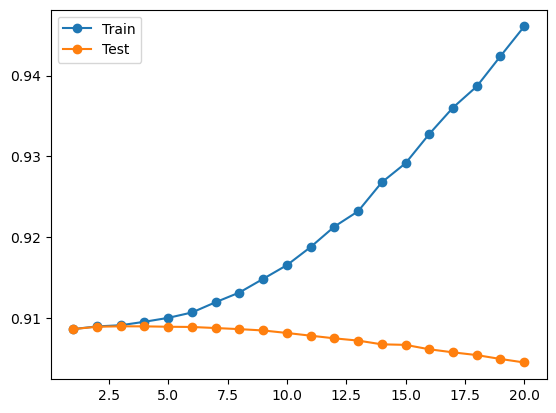

In [119]:
#plotting the graph between train and test dataframes
pyplot.plot(values, train_scores, '-o', label='Train')
pyplot.plot(values, test_scores, '-o', label='Test')
pyplot.legend()
pyplot.show()

The plot clearly shows that increasing the tree depth in the early stages results in a corresponding improvement in both train and test sets.

This continues until a depth of around 10 levels, after which the model is shown to overfit the training dataset at the cost of worse performance on the holdout dataset.

# Random Forest Classifier

In [120]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix

In [121]:
##split dataframe into X_train and y_train
X_train, y_train = data_train.drop('reordered', axis = 1), data_train.reordered

In [122]:
#INSTANTIATE RandomForestClassifier()
rfc = RandomForestClassifier(n_estimators=10, n_jobs=-1 ,random_state=101)

In [123]:
#train model
model2 = rfc.fit(X_train, y_train)

In [124]:
model2.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=101)>

In [125]:
#Set booster's range of parameters
#More parameters means that GridSearch will create and evaluate more models
forest_params = [{'max_depth': list(range(5, 10)), 'max_features': list(range(1,5)), 'n_estimators': list(range(10, 30, 5))}]

In [126]:
#INSTANTIATE XGBClassifier()
rfc = RandomForestClassifier(n_jobs=-1 ,random_state=101)

In [127]:
#define how to train the models
grid = GridSearchCV(rfc,forest_params,cv = 2, verbose = 2, n_jobs = 1)

In [128]:
#train the models with the combination of different parameters
#execution if GridSearch
model2 = grid.fit(X_train,y_train)

Fitting 2 folds for each of 80 candidates, totalling 160 fits
[CV] END .......max_depth=5, max_features=1, n_estimators=10; total time=   7.8s
[CV] END .......max_depth=5, max_features=1, n_estimators=10; total time=   5.9s
[CV] END .......max_depth=5, max_features=1, n_estimators=15; total time=   8.1s
[CV] END .......max_depth=5, max_features=1, n_estimators=15; total time=   9.9s
[CV] END .......max_depth=5, max_features=1, n_estimators=20; total time=  10.8s
[CV] END .......max_depth=5, max_features=1, n_estimators=20; total time=  10.8s
[CV] END .......max_depth=5, max_features=1, n_estimators=25; total time=  14.2s
[CV] END .......max_depth=5, max_features=1, n_estimators=25; total time=  13.5s
[CV] END .......max_depth=5, max_features=2, n_estimators=10; total time=   8.5s
[CV] END .......max_depth=5, max_features=2, n_estimators=10; total time=   7.9s
[CV] END .......max_depth=5, max_features=2, n_estimators=15; total time=  11.2s
[CV] END .......max_depth=5, max_features=2, n_

In [129]:
print("The best parameters are: /n",  grid.best_params_)

The best parameters are: /n {'max_depth': 9, 'max_features': 2, 'n_estimators': 25}


In [130]:
#store the model for prediction
model2 = gridsearch.best_estimator_

In [ ]:
#del [X_train, y_train]

In [ ]:
gc.collect()

In [134]:
data_test1 = data[data.eval_set == 'test']

In [135]:
data_test1.head()

,user_id,product_id,user_product_total,user_reorder_ratio,times_last_5,user_total_orders,user_reordered_ratio,product_total_purchase,product_reorder_ratio,eval_set,order_id
0,6,8424,1,1.000000,1.0,3,0.142857,12292,0.650504,test,1528013
1,6,10644,1,0.500000,1.0,3,0.142857,3631,0.416690,test,1528013
2,6,11068,1,0.500000,1.0,3,0.142857,3069,0.584881,test,1528013
3,6,20323,1,0.500000,1.0,3,0.142857,695,0.532374,test,1528013
4,6,21903,2,0.666667,2.0,3,0.142857,73243,0.773808,test,1528013


In [136]:
data_test1 = data_test1.set_index(['user_id','product_id'])
data_test1.head()

user_product_total  user_reorder_ratio  times_last_5  \
user_id product_id                                                         
6       8424                         1            1.000000           1.0   
        10644                        1            0.500000           1.0   
        11068                        1            0.500000           1.0   
        20323                        1            0.500000           1.0   
        21903                        2            0.666667           2.0   

                    user_total_orders  user_reordered_ratio  \
user_id product_id                                            
6       8424                        3              0.142857   
        10644                       3              0.142857   
        11068                       3              0.142857   
        20323                       3              0.142857   
        21903                       3              0.142857   

                    product_total_purchase  product_reorder_ratio eval_set  \
user_id product_id                                                           
6       8424                         12292               0.650504     test   
        10644                         3631               0.416690     test   
        11068                         3069               0.584881     test   
        20323                          695               0.532374     test   
        21903                        73243               0.773808     test   

                    order_id  
user_id product_id            
6       8424         1528013  
        10644        1528013  
        11068        1528013  
        20323        1528013  
        21903        1528013

In [137]:
data_test1 = data_test1.drop(['eval_set','order_id'], axis=1)

In [138]:
data_test1.head()

user_product_total  user_reorder_ratio  times_last_5  \
user_id product_id                                                         
6       8424                         1            1.000000           1.0   
        10644                        1            0.500000           1.0   
        11068                        1            0.500000           1.0   
        20323                        1            0.500000           1.0   
        21903                        2            0.666667           2.0   

                    user_total_orders  user_reordered_ratio  \
user_id product_id                                            
6       8424                        3              0.142857   
        10644                       3              0.142857   
        11068                       3              0.142857   
        20323                       3              0.142857   
        21903                       3              0.142857   

                    product_total_purchase  product_reorder_ratio  
user_id product_id                                                 
6       8424                         12292               0.650504  
        10644                         3631               0.416690  
        11068                         3069               0.584881  
        20323                          695               0.532374  
        21903                        73243               0.773808

In [139]:
test_pred = model2.predict(data_test1).astype(int)

In [140]:
test_pred[0:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [141]:
data_test1['prediction'] = test_pred

In [142]:
data_test1.head()

user_product_total  user_reorder_ratio  times_last_5  \
user_id product_id                                                         
6       8424                         1            1.000000           1.0   
        10644                        1            0.500000           1.0   
        11068                        1            0.500000           1.0   
        20323                        1            0.500000           1.0   
        21903                        2            0.666667           2.0   

                    user_total_orders  user_reordered_ratio  \
user_id product_id                                            
6       8424                        3              0.142857   
        10644                       3              0.142857   
        11068                       3              0.142857   
        20323                       3              0.142857   
        21903                       3              0.142857   

                    product_total_purchase  product_reorder_ratio  prediction  
user_id product_id                                                             
6       8424                         12292               0.650504           0  
        10644                         3631               0.416690           0  
        11068                         3069               0.584881           0  
        20323                          695               0.532374           0  
        21903                        73243               0.773808           0

In [143]:
final1 = data_test1.reset_index()

In [144]:
final1 = final1[['product_id', 'user_id', 'prediction']]

In [145]:
gc.collect()

2098

In [146]:
final1.head()

,product_id,user_id,prediction
0,8424,6,0
1,10644,6,0
2,11068,6,0
3,20323,6,0
4,21903,6,0


In [147]:
final1 = final1.merge(products, on = ['product_id'], how = 'inner')

In [148]:
final1

,product_id,user_id,prediction,product_name,aisle_id,department_id
0,8424,6,0,Broccoli Crown,83,4
1,8424,94,0,Broccoli Crown,83,4
2,8424,381,0,Broccoli Crown,83,4
3,8424,450,0,Broccoli Crown,83,4
4,8424,463,0,Broccoli Crown,83,4
...,...,...,...,...,...,...
1460946,43684,206182,0,Triple Berry Layer Fruit Snack,50,19
1460947,16315,206201,0,Nature's Way Long Grain & Wild Rice Rice Mix,4,9
1460948,24110,206201,0,Blasted Chocolatey Chip Marshmallow Rice Krisp...,45,19
1460949,33935,206201,0,Double Stuf Chocolate/Chocolate Variety Pack S...,100,21


In [149]:
order_test = orders.loc[orders.eval_set == 'test', ('user_id', 'order_id')]
order_test.head()

,user_id,order_id
53,6,1528013
217,19,1735923
300,25,1411408
495,35,707453
588,40,2431024


In [150]:
final1 = final1.merge(order_test, on  = 'user_id', how = 'left')
final1.head()

,product_id,user_id,prediction,product_name,aisle_id,department_id,order_id
0,8424,6,0,Broccoli Crown,83,4,1528013
1,8424,94,0,Broccoli Crown,83,4,622677
2,8424,381,0,Broccoli Crown,83,4,1185710
3,8424,450,0,Broccoli Crown,83,4,2730481
4,8424,463,0,Broccoli Crown,83,4,1493300


In [151]:
final1 = final1.drop(['user_id', 'aisle_id', 'department_id'], axis = 1)

In [152]:
final1['product_id'] = final1.product_id.astype(int)

In [153]:
del order_test

In [154]:
gc.collect()

0

In [155]:
final1.head()

,product_id,prediction,product_name,order_id
0,8424,0,Broccoli Crown,1528013
1,8424,0,Broccoli Crown,622677
2,8424,0,Broccoli Crown,1185710
3,8424,0,Broccoli Crown,2730481
4,8424,0,Broccoli Crown,1493300


In [156]:
#In this dictionary we will place as index the order_id and as values all the product name and id that the order will have
d = dict()
for row in final1.itertuples():
    if row.prediction == 1:
        try:
            d[row.order_id] += ' ' + str(row.product_id) + ' ' +  str(row.product_name)
        except:
            d[row.order_id] = str(row.product_id) + ' ' + str(row.product_name)

for order in final1.order_id:
    if order not in d:
        d[order] = 'None'

In [157]:
gc.collect()

32

In [158]:
from pprint import pprint
k = list(d.items())[:5]
pprint(k)

[(3312403, '8424 Broccoli Crown'),
 (2867048,
  '8424 Broccoli Crown 47766 Organic Avocado 5769 Organic Chicken Stock 11182 '
  'Baby Spinach 13198 85% Lean Ground Beef'),
 (2817173,
  '8424 Broccoli Crown 27531 Dairy Free Unsweetened Vanilla Coconut Milk'),
 (2653783,
  '8424 Broccoli Crown 24852 Banana 42240 Ultra Soft Facial Tissues 21709 '
  'Sparkling Lemon Water 38483 Antibacterial Concentrated Dish Soap 14890 '
  'Shelled Walnuts 11642 Dark Chocolate Squares With Raspberry Filling 19947 '
  'Fresh Citrus Antibacterial Hand Soap with Moisturizers 25651 Fast Act Anti '
  'Diarrheal'),
 (206945,
  '8424 Broccoli Crown 16797 Strawberries 45066 Honeycrisp Apple 46979 '
  'Asparagus 49683 Cucumber Kirby 16882 Baby Spring Mix 32429 Red Mango 26723 '
  'Comice Pear 30406 Butternut Squash 3298 Mozzarella String Cheese 3631 '
  'Organic Whole Milk French Vanilla Yogurt 48299 Baby Cut Carrots 44487 '
  'Lightly Salted Rice Cakes 48025 Pretzel Dipping Sticks 36507 Butter Boom '
  'Microwave

In [159]:
sub = pd.DataFrame.from_dict(d, orient = 'index')
sub.reset_index(inplace = True)

In [160]:
sub.columns = ['order_id', 'product']

In [161]:
sub.head(10)

,order_id,product
0,3312403,8424 Broccoli Crown
1,2867048,8424 Broccoli Crown 47766 Organic Avocado 5769...
2,2817173,8424 Broccoli Crown 27531 Dairy Free Unsweeten...
3,2653783,8424 Broccoli Crown 24852 Banana 42240 Ultra S...
4,206945,8424 Broccoli Crown 16797 Strawberries 45066 H...
5,2140176,8424 Broccoli Crown
6,2513595,8424 Broccoli Crown 13176 Bag of Organic Banan...
7,1103527,8424 Broccoli Crown 21903 Organic Baby Spinach...
8,2427606,8424 Broccoli Crown 24852 Banana 47766 Organic...
9,240918,8424 Broccoli Crown 9387 Granny Smith Apples 2...


In [162]:
X_train, X_test, y_train, y_test = train_test_split(data_train.drop('reordered', axis=1), data_train.reordered, test_size=0.8, random_state=42)
train_scores, test_scores = list(), list()

In [163]:
#Under/Over fitting

values = [i for i in range(5, 45, 5)]

for i in values:
	model = RandomForestClassifier(n_estimators=i, max_features = 2, max_depth = 9)
	model.fit(X_train, y_train)
	train_yhat = model.predict(X_train)
	train_acc = accuracy_score(y_train, train_yhat)
	train_scores.append(train_acc)
	test_yhat = model.predict(X_test)
	test_acc = accuracy_score(y_test, test_yhat)
	test_scores.append(test_acc)
	print('>%d, train: %f, test: %f' % (i, train_acc, test_acc))

>5, train: 0.909638, test: 0.908279
>10, train: 0.909849, test: 0.908535
>15, train: 0.909799, test: 0.908678
>20, train: 0.910000, test: 0.908659
>25, train: 0.910033, test: 0.908697
>30, train: 0.909939, test: 0.908706
>35, train: 0.909968, test: 0.908705
>40, train: 0.910092, test: 0.908720


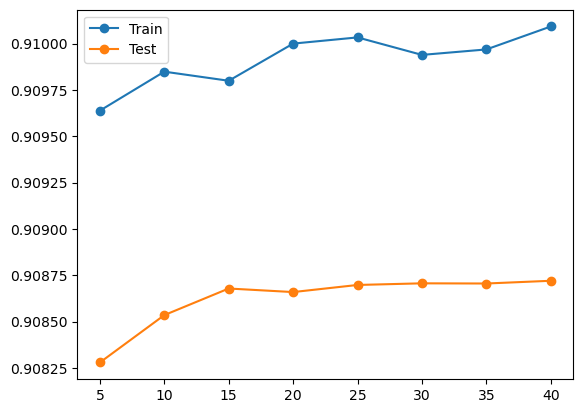

In [164]:
##plotting the graph between train and test dataframes
pyplot.plot(values, train_scores, '-o', label='Train')
pyplot.plot(values, test_scores, '-o', label='Test')
pyplot.legend()
pyplot.show()

The plot clearly shows that increasing the tree depth in the early stages results in a corresponding improvement in both train and test sets.

This continues until a depth of around 10 levels, after which the model is shown to overfit the training dataset at the cost of worse performance on the holdout dataset.

# Logistic Regression

In [165]:
#Scaling the data
from sklearn.preprocessing import StandardScaler

In [166]:
#Logistic Regression with cross-validation
from sklearn.linear_model import LogisticRegressionCV

In [167]:
X_train, X_val, y_train, y_val = train_test_split(data_train.drop('reordered', axis=1), data_train.reordered, test_size=0.8, random_state=42)

In [168]:
#Initializing StandardScaler(0)
scaler = StandardScaler()

In [169]:
#fit_transform the training set
#transform the test set as we predict based on the test set
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [170]:
#Initializing LogisticRegressionCV()
log_model = LogisticRegressionCV(cv = 3, random_state = 42)

In [171]:
#fitting the model 
model3 = log_model.fit(scaled_X_train,y_train)

In [172]:
y_val_pred = (model3.predict_proba(X_val)[:,1] >= 0.21).astype(int)

In [173]:
#best C value
model3.C_

array([0.0001])

In [174]:
model3.get_params()

{'Cs': 10,
 'class_weight': None,
 'cv': 3,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1.0,
 'l1_ratios': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'refit': True,
 'scoring': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0}

In [175]:
#del [X_train, y_train]

In [176]:
gc.collect()

4307

In [177]:
data_test2 = data[data.eval_set == 'test']

In [178]:
data_test2.head()

,user_id,product_id,user_product_total,user_reorder_ratio,times_last_5,user_total_orders,user_reordered_ratio,product_total_purchase,product_reorder_ratio,eval_set,order_id
0,6,8424,1,1.000000,1.0,3,0.142857,12292,0.650504,test,1528013
1,6,10644,1,0.500000,1.0,3,0.142857,3631,0.416690,test,1528013
2,6,11068,1,0.500000,1.0,3,0.142857,3069,0.584881,test,1528013
3,6,20323,1,0.500000,1.0,3,0.142857,695,0.532374,test,1528013
4,6,21903,2,0.666667,2.0,3,0.142857,73243,0.773808,test,1528013


In [179]:
data_test2 = data_test2.set_index(['user_id', 'product_id'])
data_test2.head()

user_product_total  user_reorder_ratio  times_last_5  \
user_id product_id                                                         
6       8424                         1            1.000000           1.0   
        10644                        1            0.500000           1.0   
        11068                        1            0.500000           1.0   
        20323                        1            0.500000           1.0   
        21903                        2            0.666667           2.0   

                    user_total_orders  user_reordered_ratio  \
user_id product_id                                            
6       8424                        3              0.142857   
        10644                       3              0.142857   
        11068                       3              0.142857   
        20323                       3              0.142857   
        21903                       3              0.142857   

                    product_total_purchase  product_reorder_ratio eval_set  \
user_id product_id                                                           
6       8424                         12292               0.650504     test   
        10644                         3631               0.416690     test   
        11068                         3069               0.584881     test   
        20323                          695               0.532374     test   
        21903                        73243               0.773808     test   

                    order_id  
user_id product_id            
6       8424         1528013  
        10644        1528013  
        11068        1528013  
        20323        1528013  
        21903        1528013

In [180]:
data_test2 = data_test2.drop(['eval_set', 'order_id'], axis = 1)

In [181]:
data_test2.head()

user_product_total  user_reorder_ratio  times_last_5  \
user_id product_id                                                         
6       8424                         1            1.000000           1.0   
        10644                        1            0.500000           1.0   
        11068                        1            0.500000           1.0   
        20323                        1            0.500000           1.0   
        21903                        2            0.666667           2.0   

                    user_total_orders  user_reordered_ratio  \
user_id product_id                                            
6       8424                        3              0.142857   
        10644                       3              0.142857   
        11068                       3              0.142857   
        20323                       3              0.142857   
        21903                       3              0.142857   

                    product_total_purchase  product_reorder_ratio  
user_id product_id                                                 
6       8424                         12292               0.650504  
        10644                         3631               0.416690  
        11068                         3069               0.584881  
        20323                          695               0.532374  
        21903                        73243               0.773808

In [182]:
test_pred = model3.predict(data_test2).astype(int)

In [183]:
test_pred = (model3.predict_proba(data_test2)[:,1] >= 0.21).astype(int)
test_pred[0:20]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0])

In [184]:
test_pred[0:100]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1])

In [185]:
data_test2['prediction'] = test_pred

In [186]:
data_test2.head()

user_product_total  user_reorder_ratio  times_last_5  \
user_id product_id                                                         
6       8424                         1            1.000000           1.0   
        10644                        1            0.500000           1.0   
        11068                        1            0.500000           1.0   
        20323                        1            0.500000           1.0   
        21903                        2            0.666667           2.0   

                    user_total_orders  user_reordered_ratio  \
user_id product_id                                            
6       8424                        3              0.142857   
        10644                       3              0.142857   
        11068                       3              0.142857   
        20323                       3              0.142857   
        21903                       3              0.142857   

                    product_total_purchase  product_reorder_ratio  prediction  
user_id product_id                                                             
6       8424                         12292               0.650504           1  
        10644                         3631               0.416690           1  
        11068                         3069               0.584881           1  
        20323                          695               0.532374           1  
        21903                        73243               0.773808           1

In [187]:
final2 = data_test2.reset_index()

In [188]:
final2 = final2[['product_id', 'user_id', 'prediction']]

In [189]:
gc.collect()

0

In [190]:
final2.head()

,product_id,user_id,prediction
0,8424,6,1
1,10644,6,1
2,11068,6,1
3,20323,6,1
4,21903,6,1


In [191]:
final2 = final2.merge(products, on = ['product_id'], how = 'inner')

In [192]:
final2

,product_id,user_id,prediction,product_name,aisle_id,department_id
0,8424,6,1,Broccoli Crown,83,4
1,8424,94,1,Broccoli Crown,83,4
2,8424,381,1,Broccoli Crown,83,4
3,8424,450,1,Broccoli Crown,83,4
4,8424,463,1,Broccoli Crown,83,4
...,...,...,...,...,...,...
1460946,43684,206182,0,Triple Berry Layer Fruit Snack,50,19
1460947,16315,206201,0,Nature's Way Long Grain & Wild Rice Rice Mix,4,9
1460948,24110,206201,0,Blasted Chocolatey Chip Marshmallow Rice Krisp...,45,19
1460949,33935,206201,0,Double Stuf Chocolate/Chocolate Variety Pack S...,100,21


In [193]:
orders_test = orders.loc[orders.eval_set == 'test', ('user_id', 'order_id')]

In [194]:
orders_test.head()

,user_id,order_id
53,6,1528013
217,19,1735923
300,25,1411408
495,35,707453
588,40,2431024


In [195]:
final2 = final2.merge(orders_test, on = 'user_id', how = 'left')

In [196]:
final2.head()

,product_id,user_id,prediction,product_name,aisle_id,department_id,order_id
0,8424,6,1,Broccoli Crown,83,4,1528013
1,8424,94,1,Broccoli Crown,83,4,622677
2,8424,381,1,Broccoli Crown,83,4,1185710
3,8424,450,1,Broccoli Crown,83,4,2730481
4,8424,463,1,Broccoli Crown,83,4,1493300


In [197]:
final2 = final2.drop(['user_id', 'department_id', 'aisle_id'], axis = 1)

In [198]:
final2['product_id'] = final2.product_id.astype(int)

In [199]:
del orders_test

In [200]:
#del orders

In [201]:
gc.collect()

0

In [202]:
final2.head()

,product_id,prediction,product_name,order_id
0,8424,1,Broccoli Crown,1528013
1,8424,1,Broccoli Crown,622677
2,8424,1,Broccoli Crown,1185710
3,8424,1,Broccoli Crown,2730481
4,8424,1,Broccoli Crown,1493300


In [203]:
#In this dictionary we will place as index the order_id and as values all the product name and id that the order will have
d = dict()
for row in final2.itertuples():
    if row.prediction == 1:
        try:
            d[row.order_id] += ' ' + str(row.product_id) + ' ' +  str(row.product_name)
        except:
            d[row.order_id] = str(row.product_id) + ' ' + str(row.product_name)

for order in final2.order_id:
    if order not in d:
        d[order] = 'None'

In [204]:
gc.collect()

32

In [205]:
from pprint import pprint
k = list(d.items())[:5]
pprint(k)

[(1528013,
  '8424 Broccoli Crown 10644 Italian Extra Virgin Olive Oil 11068 Medium '
  'Cheddar Cheese Block 20323 Strained Tomatoes 21903 Organic Baby Spinach '
  '25659 Organic Coconut Milk 27521 Organic Lacinato (Dinosaur) Kale 38293 '
  'Ground Turkey Breast 40992 Chopped Tomatoes 45007 Organic Zucchini 48679 '
  'Organic Garnet Sweet Potato (Yam) 49401 Chicken Base, Organic'),
 (622677,
  '8424 Broccoli Crown 2192 Bold & Crispy Zesties! Crispy Seasoned French '
  'Fried Potatoes 23734 Sour Cream 5025 Green Onions 34358 Garlic 34969 Red '
  "Vine Tomato 44142 Red Onion 17264 Stand 'n Stuff Taco Shells 25952 Original "
  'Potato Chips 40593 Cream Cheese 1541 Jumbo Grade A Eggs 3990 Natural Sharp '
  'Cheddar Sliced Cheese 4058 Mild Fire Roasted Diced Green Chiles 4595 '
  'Italian Dry Salame 5097 Mexican Style Taco Shredded Cheese 11615 Original '
  'Prepared Cheese Product 15294 Butter Hamburger Buns 16185 Sharp Cheddar '
  'Cheese 17616 Goldfish Cheddar Baked Snack Crackers 17663

In [206]:
sub = pd.DataFrame.from_dict(d, orient = 'index')
sub.reset_index(inplace = True)

In [207]:
sub.columns = ['order_id', 'products']

In [208]:
#final prediction
sub.head(10)

,order_id,products
0,1528013,8424 Broccoli Crown 10644 Italian Extra Virgin...
1,622677,8424 Broccoli Crown 2192 Bold & Crispy Zesties...
2,1185710,8424 Broccoli Crown 10644 Italian Extra Virgin...
3,2730481,8424 Broccoli Crown 21903 Organic Baby Spinach...
4,1493300,8424 Broccoli Crown 21903 Organic Baby Spinach...
5,1901134,8424 Broccoli Crown 45007 Organic Zucchini 350...
6,391588,8424 Broccoli Crown 21903 Organic Baby Spinach...
7,1176544,8424 Broccoli Crown 45007 Organic Zucchini 196...
8,1237487,8424 Broccoli Crown 21903 Organic Baby Spinach...
9,1601439,8424 Broccoli Crown 21903 Organic Baby Spinach...
